In [78]:
from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr
import os
from mpl_toolkits.mplot3d import Axes3D
import math
import time
from ipywidgets import interact
from ipywidgets import widgets
from IPython.display import clear_output
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

class regression_sliders:
    
    def __init__(self):
        a = 0
        self.data = []
        self.cost_history = []
        self.x_orig = []
        
    # load in a two-dimensional dataset from csv - input should be in first column, oiutput in second column, no headers 
    def load_linear_data(self,csvname):
        # load data
        self.data = np.asarray(pd.read_csv(csvname,header = None))
        self.data[:,0] = self.data[:,0] - np.mean(self.data[:,0])
        self.data[:,1] = self.data[:,1] - np.mean(self.data[:,1])

    def load_sinusoidal_data(self,csvname):
        # load data
        self.data = np.asarray(pd.read_csv(csvname,header = None))
        self.data[:,0] = self.data[:,0] - np.mean(self.data[:,0])
        self.data[:,1] = self.data[:,1] - np.mean(self.data[:,1])
        self.x_orig = self.data[:,0].copy()
        
        # sin transform
        self.data[:,0] = np.sin(2*np.pi*self.data[:,0])
        
    #### computation functions ####    
    def compute_cost(self,x,y,b,w):
        cost = 0
        for p in range(0,len(y)):
            cost +=(b + w*x[p] - y[p])**2
        return cost
                
    # gradient descent function
    def run_grad_descent(self,inits,max_its):    
        # peel off coordinates
        x = self.data[:,0]
        y = self.data[:,1]
        
        # initialize parameters - we choose this special to illustrate whats going on
        b = inits[0]    # initial intercept
        w = inits[1]      # initial slope
        P = len(y)
        
        # plot first parameters on cost surface
        cost_val = self.compute_cost(x,y,b,w)
        self.cost_history = []
        self.cost_history.append([b,w,cost_val])
        
        # gradient descent loop
        for k in range(1,max_its+1):   

            # compute each partial derivative - gprime_b is partial with respect to b, gprime_w the partial with respect to w            
            gprime_b = 0
            gprime_w = 0
            for p in range(0,P):
                temp = 2*(b + w*x[p] - y[p])
                gprime_b += temp
                gprime_w += temp*x[p]
            
            # set alpha via line search
            grad = np.asarray([gprime_b,gprime_w])
            grad.shape = (len(grad),1)
            alpha = self.line_search(x,y,b,w,grad)
            
            # take descent step in each partial derivative
            b = b - alpha*gprime_b
            w = w - alpha*gprime_w

            # compute cost function value 
            cost_val = self.compute_cost(x,y,b,w)
            self.cost_history.append([b,w,cost_val])   
        
    # line search module
    def line_search(self,x,y,b,w,grad):
        alpha = 1
        t = 0.1
        g_w = self.compute_cost(x,y,b,w)
        norm_w = np.linalg.norm(grad)**2
        while self.compute_cost(x,y,b - alpha*grad[0],w - alpha*grad[1]) > g_w - alpha*0.5*norm_w:
            alpha = t*alpha
        return alpha

    ##### plotting functions ####
    # show the net transformation using slider
    def line_fitting_slider(self):  
        # pull out coordinates
        x = self.data[:,0]
        y = self.data[:,1]
        
        ##### precomputations #####
        # precompute fits input
        x_fit = np.linspace(np.min(x)-1, np.max(x)+1, 100)

        # precompute surface 
        r = np.linspace(-3,3,100)    
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))

        # generate surface based on given data - done very lazily - recomputed each time
        g = 0
        P = len(y)
        for p in range(0,P):
            g+= (s + t*x[p] - y[p])**2

        # reshape and plot the surface, as well as where the zero-plane is
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        g.shape = (np.size(r),np.size(r))
        
        # slider mechanism
        def show_fit(step):
            ##### start plotting #####  
            fig = plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122,projection='3d')

            ### initialize plot data points and fit
            # initialize fit
            vals = self.cost_history[step]
            b = vals[0]
            w = vals[1]
            y_fit = b + x_fit*w
            ax1.plot(x_fit,y_fit,'-r',linewidth = 3) 

            # initialize points
            ax1.scatter(x,y)

            # clean up panel
            xgap = float(max(x) - min(x))/float(10)
            ax1.set_xlim([min(x)-xgap,max(x)+xgap])
            ygap = float(max(y) - min(y))/float(10)
            ax1.set_ylim([min(y)-ygap,max(y)+ygap])
            ax1.set_xticks([])
            ax1.set_yticks([])

            ### plot surface
            ax2.plot_surface(s,t,g,alpha = 0.15)
            ax2.plot_surface(s,t,g*0,alpha = 0.1)

            # plot all points faintly
            bs = []
            ws = []
            costs = []
            for i in range(len(self.cost_history)):
                bwg = self.cost_history[i]
                b = bwg[0]
                w = bwg[1]
                cost = bwg[2]
                bs.append(b)
                ws.append(w)
                costs.append(cost)
                
            ax2.scatter(bs,ws,costs,color = 'm',marker = 'x',linewidth = 3, alpha = 0.1)            

            # plot gradient descent initial point
            b = vals[0]
            w = vals[1]
            cost = vals[2]
            ax2.scatter(b,w,cost,marker = 'o',color = 'r',s = 50,edgecolor = 'k',linewidth = 1)            
            
            # clean up panel
            ax2.view_init(40,70)        
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_zticks([])

            ax2.set_xlabel('intercept ',fontsize = 14,labelpad = -5)
            ax2.set_ylabel('slope  ',fontsize = 14,labelpad = -5)

            ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
            ax2.set_zlabel('cost  ',fontsize = 14, rotation = 0,labelpad = 1)
    
        interact(show_fit, step=widgets.IntSlider(min=0,max=len(self.cost_history)-1,step=1,value=0))
        
    
    # show the net transformation using slider
    def sine_fitting_slider(self):  
        # pull out coordinates
        x_orig = self.x_orig
        x_tran = self.data[:,0]
        y = self.data[:,1]
        
        ##### precomputations #####
        # precompute fits input
        x_fit = np.linspace(-4.5,4.5,200)    
        
        # precompute surface 
        r = np.linspace(-3,3,100)    
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))

        # generate surface based on given data - done very lazily - recomputed each time
        g = 0
        P = len(y)
        for p in range(0,P):
            g+= (s + t*x_tran[p] - y[p])**2

        # reshape and plot the surface, as well as where the zero-plane is
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        g.shape = (np.size(r),np.size(r))
        
        # slider mechanism
        def show_fit(step):
            ##### start plotting #####  
            fig = plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122,projection='3d')

            ### initialize plot data points and fit
            # initialize fit
            vals = self.cost_history[step]
            b = vals[0]
            w = vals[1]
            y_fit = b + np.sin(2*np.pi*x_fit)*w
            ax1.plot(x_fit,y_fit,'-r',linewidth = 3) 

            # initialize points
            ax1.scatter(x_orig,y)

            # clean up panel
            xgap = float(max(x_orig) - min(x_orig))/float(10)
            ax1.set_xlim([min(x_orig)-xgap,max(x_orig)+xgap])
            ygap = float(max(y) - min(y))/float(10)
            ax1.set_ylim([min(y)-ygap,max(y)+ygap])
            ax1.set_xticks([])
            ax1.set_yticks([])

            ### plot surface
            ax2.plot_surface(s,t,g,alpha = 0.15)
            ax2.plot_surface(s,t,g*0,alpha = 0.1)

            # plot all points faintly
            bs = []
            ws = []
            costs = []
            for i in range(len(self.cost_history)):
                bwg = self.cost_history[i]
                b = bwg[0]
                w = bwg[1]
                cost = bwg[2]
                bs.append(b)
                ws.append(w)
                costs.append(cost)
                
            ax2.scatter(bs,ws,costs,color = 'm',marker = 'x',linewidth = 3, alpha = 0.1)            

            # plot gradient descent initial point
            b = vals[0]
            w = vals[1]
            cost = vals[2]
            ax2.scatter(b,w,cost,marker = 'o',color = 'r',s = 50,edgecolor = 'k',linewidth = 1)            
            
            # clean up panel
            ax2.view_init(50,20)        
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_zticks([])

            ax2.set_xlabel('intercept ',fontsize = 14,labelpad = -5)
            ax2.set_ylabel('slope  ',fontsize = 14,labelpad = -5)

            ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
            ax2.set_zlabel('cost  ',fontsize = 14, rotation = 0,labelpad = 1)
    
        interact(show_fit, step=widgets.IntSlider(min=0,max=len(self.cost_history)-1,step=1,value=0))

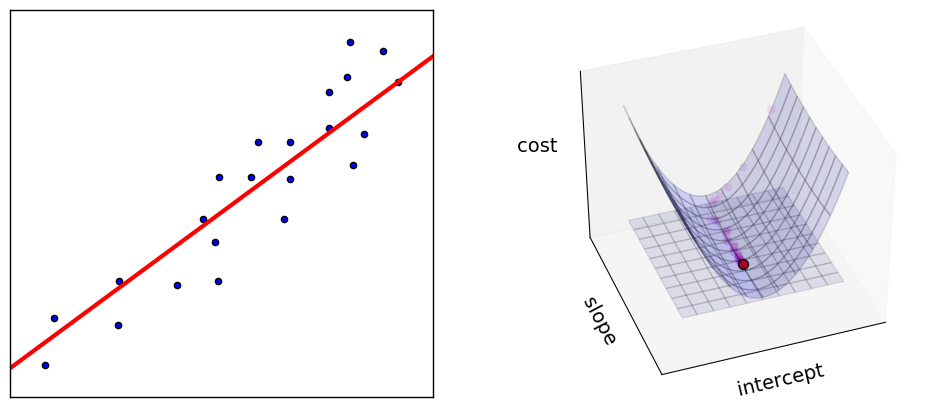

In [84]:
# import statements
%matplotlib inline
import sys
sys.path.append('../../demo_python_backend_files')
from IPython import display            

# call the demonstration
csvname = '../../demo_datasets/toy_regression_data.csv'
demo = regression_sliders()
demo.load_linear_data(csvname)

# run gradient descent
demo.run_grad_descent(inits = [-2.5,-3],max_its = 50)

# run slider
demo.line_fitting_slider()

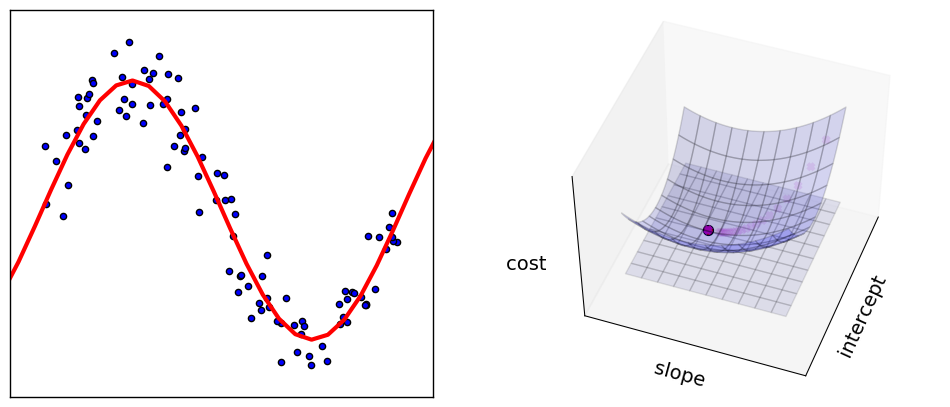

In [85]:
# import statements
%matplotlib inline
import sys
sys.path.append('../../demo_python_backend_files')
from IPython import display            

# call the demonstration
csvname = 'sinusoidal_data.csv'
demo = regression_sliders()
demo.load_sinusoidal_data(csvname)

# run gradient descent
demo.run_grad_descent(inits = [-2.5,2.5],max_its = 50)

# run slider
demo.sine_fitting_slider()

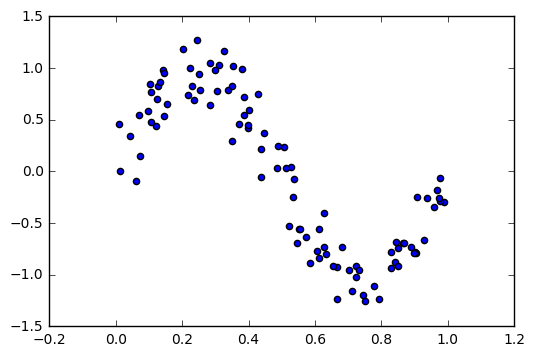

In [81]:
s = np.random.rand(100)
t = np.sin(2*np.pi*s) + 0.2*np.random.randn(100)
plt.scatter(s,t)
s.shape = (len(s),1)
t.shape = (len(t),1)
data = np.concatenate((s,t),axis = 1)
data = pd.DataFrame(data)
data.to_csv('sinusoidal_data.csv',header = None,index = False)